# Importing the libraries

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image_dataset_from_directory
import io
import os
from datetime import datetime
import pandas as pd
from skimage.io.collection import ImageCollection
from skimage.io import imread
from skimage.io import imshow
from skimage.io import imsave

print (tf.__version__)

2.4.0


### Checking if the GPU is connected and running 

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


# Sorting the images in the dataset into folders based on the class

## Import dataset 

In [3]:
os.getcwd()

os.chdir('E:\\Cancer Project')

dataset_info = pd.read_csv('HAM10000_metadata.csv')

dataset_info

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face


## Understanding the characteristics of the dataset

In [4]:
# All images have been labelled correclty 

dataset_info.dx.unique()

array(['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec'], dtype=object)

In [5]:
#There seems to be some missing data under the age variable

# Even though the age variable of the dataset has null values, we will continue to include these datapoints since the 
# CNN algorithm only takes the image as input. Hence if we have the image and the respective label we could train the 
# algorithm, despite there being missing values under the age variable 

dataset_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


In [6]:
if dataset_info.duplicated().unique() == False:
    print ('There are no duplicated images')
else:
    print ('There are duplicated images')

There are no duplicated images


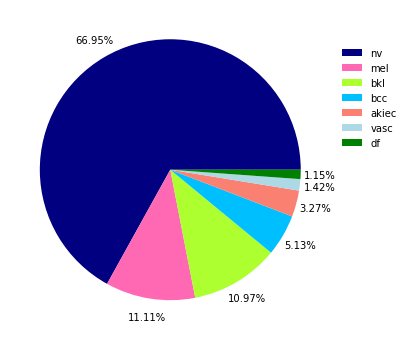


-> The dataset is clearly imbalanced, dominated by the nv class. Therefore we will need to address this issue


In [7]:
dataset_info.dx.value_counts()

plt.figure(figsize = (10,6))

plt.pie(dataset_info.dx.value_counts(), autopct = '%1.2f%%',pctdistance = 1.15, colors = ['navy', 'hotpink','greenyellow', \
                                                                                         'deepskyblue', 'salmon','lightblue', 'green'])
plt.legend(labels = dataset_info.dx.value_counts().reset_index()['index'].tolist(), loc = 'upper left', bbox_to_anchor = (1,0.9),\
          frameon = False)
plt.show()

print ('')
print ('-> The dataset is clearly imbalanced, dominated by the nv class. Therefore we will need to address this issue')

# Split the data into the Traning set and Test set

In [8]:
from sklearn.model_selection import train_test_split
train_dataframe, test_dataframe = train_test_split(dataset_info, test_size = 0.2, random_state = 0)

In [9]:
# The train dataset has images from all classes
train_dataframe.dx.unique()

array(['nv', 'bcc', 'mel', 'akiec', 'bkl', 'df', 'vasc'], dtype=object)

In [10]:
# The test dataset has images from all classes
test_dataframe.dx.unique()

array(['nv', 'bcc', 'mel', 'bkl', 'akiec', 'vasc', 'df'], dtype=object)

# Identifying imbalance

In [11]:
# Identifying the number of images required to ensure that there are equal number of images under each class

imbalance = []
for i in train_dataframe.dx.unique():
    imbalance.append((i, len(train_dataframe.dx[train_dataframe.dx == 'nv']) - len(train_dataframe.dx[train_dataframe.dx == i])))
imbalance

[('nv', 0),
 ('bcc', 4951),
 ('mel', 4464),
 ('akiec', 5088),
 ('bkl', 4453),
 ('df', 5268),
 ('vasc', 5242)]

In [12]:
# The Number of times a single image in an imbalanced class should be reproduced inorder to reach parity between classes

Image_gen = []
for i, j in enumerate(train_dataframe.dx.unique()):
    if len(train_dataframe.dx[train_dataframe.dx == j])!= 0:
        Image_gen.append((j, imbalance[i][1]//len(train_dataframe.dx[train_dataframe.dx == j])))
    else:
        pass
Image_gen

[('nv', 0),
 ('bcc', 12),
 ('mel', 5),
 ('akiec', 19),
 ('bkl', 4),
 ('df', 61),
 ('vasc', 46)]

# Creating the Augementing fucnction

In [13]:
data_augmentor = tf.keras.Sequential([tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
                                        tf.keras.layers.experimental.preprocessing.RandomRotation(0.4),
                                        tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
                                        tf.keras.layers.experimental.preprocessing.RandomZoom(-0.3),
                                        tf.keras.layers.experimental.preprocessing.RandomContrast(0.1)])

# Saving newly generated images in the respective folders

## Training set

In [14]:
for i,j in enumerate(train_dataframe.dx.unique()):
    if j == 'nv': # << Dominant class
        if not os.path.exists('E:\\Cancer Project\\Labelled_Dataset_1\\Train_set\\'+ str(j)): # << Update based on the location where you want to save the newly generated images
            # This should ideally be within the Train_set folder since we want to save the newly generated images within the sub-folders for each category under the Train_set folder
            os.mkdir('E:\\Cancer Project\\Labelled_Dataset_1\\Train_set\\'+ str(j)) 
        os.chdir('E:\\Cancer Project\\All_images') # << reset the directory to the location will all images
        for k in train_dataframe.image_id[dataset_info.dx == j]:
            os.chdir('E:\\Cancer Project\\All_images') # << reset the directory to the location will all images
            data = imread(k+'.jpg')
            os.chdir('E:\\Cancer Project\\Labelled_Dataset_1\\Train_set\\'+ str(j)) # << updating the location to save the newly generated image 
            imsave('{}.jpg'.format(k), data)
    
    else: #<< Other classes
        if not os.path.exists('E:\\Cancer Project\\Labelled_Dataset_1\\Train_set\\'+ str(j)):
            os.mkdir('E:\\Cancer Project\\Labelled_Dataset_1\\Train_set\\'+ str(j))
        os.chdir('E:\\Cancer Project\\All_images')
        for k in train_dataframe.image_id[dataset_info.dx == j]:
            for r in range (0,Image_gen[i][1]):
                os.chdir('E:\\Cancer Project\\All_images')
                raw_image = imread(k+'.jpg')
                augmented_image = tf.expand_dims(raw_image,0)
                processed_image = data_augmentor(augmented_image) 
                os.chdir('E:\\Cancer Project\\Labelled_Dataset_1\\Train_set\\'+ str(j))
                imsave('{}_{}.jpg'.format(k,r), tf.squeeze(processed_image))

<ipython-input-14-f5781f63b690>:23: UserWarning: ISIC_0032170_0.jpg is a low contrast image
  imsave('{}_{}.jpg'.format(k,r), tf.squeeze(processed_image))
<ipython-input-14-f5781f63b690>:23: UserWarning: ISIC_0032170_1.jpg is a low contrast image
  imsave('{}_{}.jpg'.format(k,r), tf.squeeze(processed_image))
<ipython-input-14-f5781f63b690>:23: UserWarning: ISIC_0032170_2.jpg is a low contrast image
  imsave('{}_{}.jpg'.format(k,r), tf.squeeze(processed_image))
<ipython-input-14-f5781f63b690>:23: UserWarning: ISIC_0024337_0.jpg is a low contrast image
  imsave('{}_{}.jpg'.format(k,r), tf.squeeze(processed_image))
<ipython-input-14-f5781f63b690>:23: UserWarning: ISIC_0024337_1.jpg is a low contrast image
  imsave('{}_{}.jpg'.format(k,r), tf.squeeze(processed_image))
<ipython-input-14-f5781f63b690>:23: UserWarning: ISIC_0024337_3.jpg is a low contrast image
  imsave('{}_{}.jpg'.format(k,r), tf.squeeze(processed_image))


## Test set

In [15]:
for i in dataset_info.dx.unique():
    if not os.path.exists('E:\\Cancer Project\\Labelled_Dataset_1\\Test_set\\'+ str(i)): # << Update based on the location where you want to save the newly generated images
            # This should ideally be within the Test_set folder since we want to save the newly generated images within the sub-folders for each category under the Test_set folder
        os.mkdir('E:\\Cancer Project\\Labelled_Dataset_1\\Test_set\\'+ str(i))
    os.chdir('E:\\Cancer Project\\All_images') # << reset the directory to the location will all images
    for j in test_dataframe.image_id[dataset_info.dx == i]:
        os.chdir('E:\\Cancer Project\\All_images') # << reset the directory to the location will all images
        data = imread(j+'.jpg')
        os.chdir('E:\\Cancer Project\\Labelled_Dataset_1\\Test_set\\'+ str(i)) # << updating the location to save the newly generated image 
        imsave('{}.jpg'.format(j), data)